<a href="https://colab.research.google.com/github/Dataspiritmelody/Artificial_Neural_Networks/blob/main/Artificial_Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import VGG16
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
import warnings
warnings.filterwarnings('ignore')



# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

Lumpy Skin Images: 324
Normal Skin Images: 700
Total Images: 1024


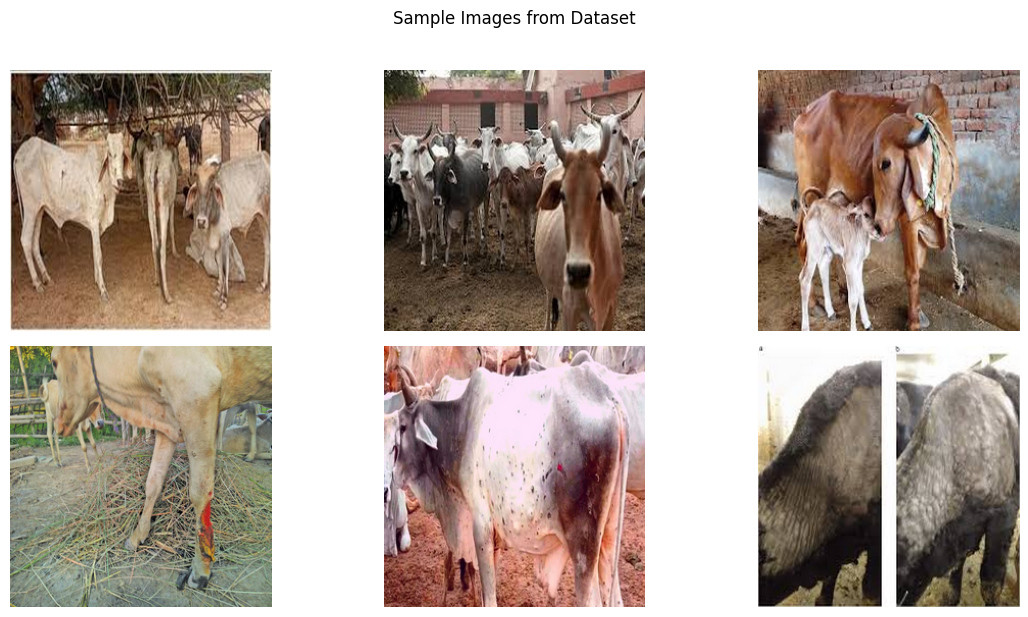

In [ ]:
# Load and Explore the Dataset


# Define paths
lumpy_path = "/content/drive/MyDrive/Lumpy Skin Images Dataset/Lumpy Skin"
normal_path = "/content/drive/MyDrive/Lumpy Skin Images Dataset/Normal Skin"

# Function to load images
def load_images(folder_path, label):
    images = []
    labels = []
    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)
        try:
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
            img = cv2.resize(img, (256, 256))  # Resize to 256x256
            images.append(img)
            labels.append(label)
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
    return images, labels

# Load lumpy skin images
lumpy_images, lumpy_labels = load_images(lumpy_path, 1)

# Load normal skin images
normal_images, normal_labels = load_images(normal_path, 0)

# Combine datasets
X = np.array(lumpy_images + normal_images)
y = np.array(lumpy_labels + normal_labels)

# Check class distribution
print(f"Lumpy Skin Images: {len(lumpy_images)}")
print(f"Normal Skin Images: {len(normal_images)}")
print(f"Total Images: {len(X)}")

# Plot sample images
plt.figure(figsize=(12, 6))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(X[np.random.randint(0, len(X))])
    plt.axis('off')
plt.suptitle('Sample Images from Dataset', y=1.02)
plt.tight_layout()
plt.show()

In [ ]:
# Data Preprocessing and Splitting

# Normalize pixel values to [0, 1]
X = X / 255.0

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Further split training set into training and validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=42)

# Convert labels to categorical (one-hot encoding)
y_train_cat = to_categorical(y_train, num_classes=2)
y_val_cat = to_categorical(y_val, num_classes=2)
y_test_cat = to_categorical(y_test, num_classes=2)

print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")
print(f"Test set shape: {X_test.shape}")

Training set shape: (655, 256, 256, 3)
Validation set shape: (164, 256, 256, 3)
Test set shape: (205, 256, 256, 3)


In [ ]:
# Data  Augmentation

# Create data generator for augmentation
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,

    fill_mode='nearest'
)

train_generator = train_datagen.flow(X_train, y_train_cat, batch_size=32)

# For validation and test, we only rescale
val_datagen = ImageDataGenerator()
val_generator = val_datagen.flow(X_val, y_val_cat, batch_size=32)

In [ ]:
# Build CNN Model

def build_cnn_model(input_shape=(256, 256, 3)):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),


        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),

        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),

        Conv2D(256, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),

        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(2, activation='softmax')
    ])

    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

# Build and summarize model
cnn_model = build_cnn_model()
cnn_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)                    │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 60, 60, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 30, 30, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 28, 28, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 14, 14, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 50176)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │      25,690,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 2)                   │           1,026 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 26,080,066 (99.49 MB)

 Trainable params: 26,080,066 (99.49 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 123s 6s/step - accuracy: 0.6701 - loss: 0.6645 - val_accuracy: 0.6812 - val_loss: 0.6072
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 22s 874ms/step - accuracy: 0.8125 - loss: 0.5033 - val_accuracy: 0.6875 - val_loss: 0.6097
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 202s 7s/step - accuracy: 0.6846 - loss: 0.6078 - val_accuracy: 0.6812 - val_loss: 0.5747
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 15s 430ms/step - accuracy: 0.8438 - loss: 0.3922 - val_accuracy: 0.6875 - val_loss: 0.5746
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 200s 8s/step - accuracy: 0.7213 - loss: 0.5360 - val_accuracy: 0.6938 - val_loss: 0.5260
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 22s 819ms/step - accuracy: 0.5000 - loss: 0.6727 - val_accuracy: 0.6875 - val_loss: 0.5228
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 141s 6s/step - accuracy: 0.7244 - loss: 0.5062 - val_accuracy: 0.7500 - val_loss: 0.4822
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 422ms/step - accuracy: 0.7812 - loss: 0.4564 - val_accu

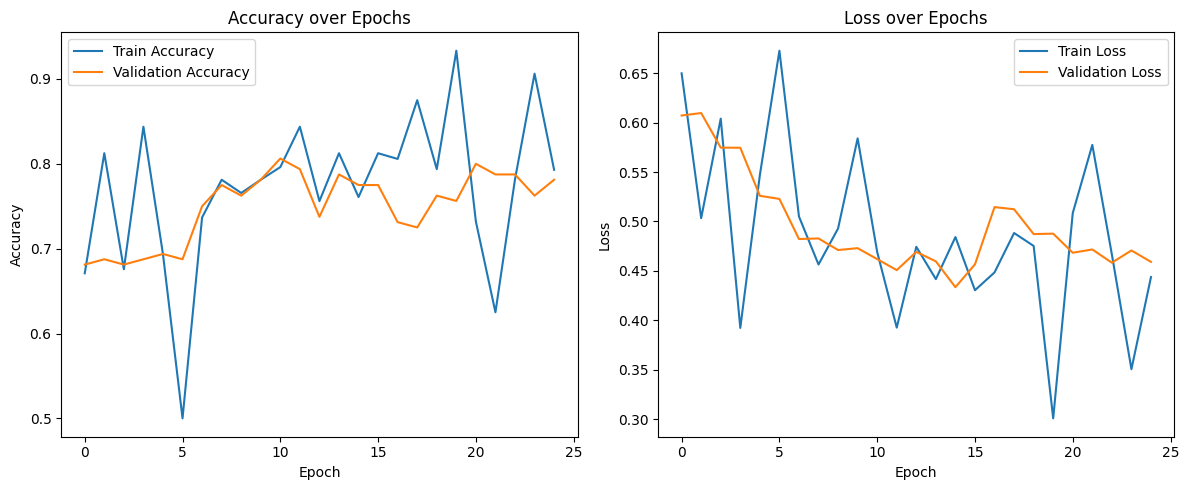

In [ ]:
# Train the Model
# Define early stopping

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = cnn_model.fit(
    train_generator,
    steps_per_epoch=len(X_train) // 32,
    epochs=100,
    validation_data=val_generator,
    validation_steps=len(X_val) // 32,
    callbacks=[early_stopping]
)

# Plot training history
def plot_history(history):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(history)

7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.7644 - loss: 0.4652
Test Accuracy: 0.7707
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step

Classification Report:
              precision    recall  f1-score   support

 Normal Skin       0.83      0.84      0.83       140
  Lumpy Skin       0.65      0.62      0.63        65

    accuracy                           0.77       205
   macro avg       0.74      0.73      0.73       205
weighted avg       0.77      0.77      0.77       205



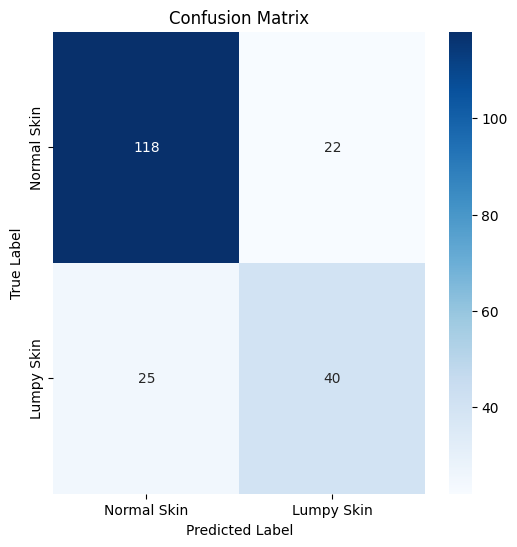

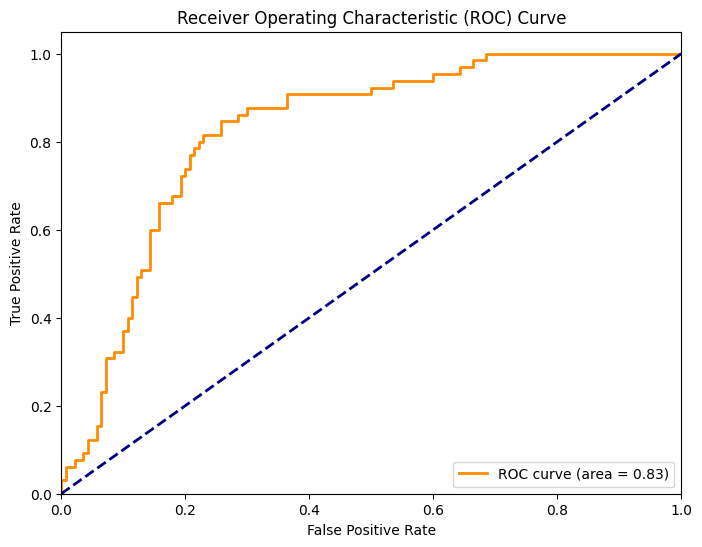

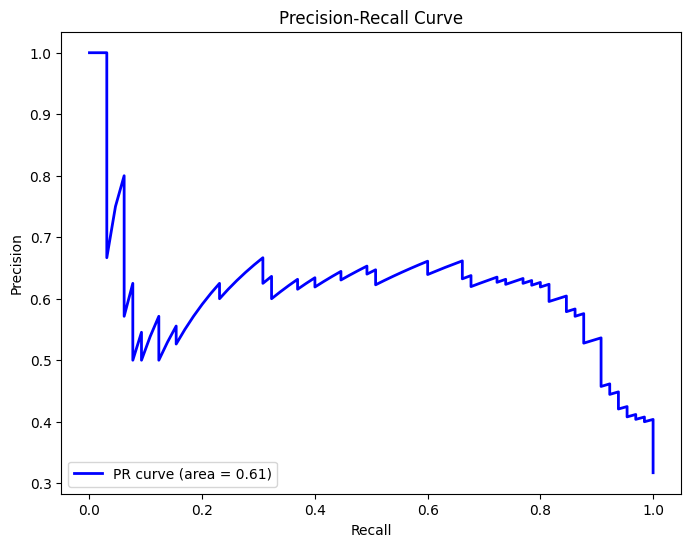

In [ ]:
# Evaluate the Model


# Evaluate on test set
test_loss, test_acc = cnn_model.evaluate(X_test, y_test_cat)
print(f"Test Accuracy: {test_acc:.4f}")

# Predictions
y_pred = cnn_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes, target_names=['Normal Skin', 'Lumpy Skin']))

# Confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

plot_confusion_matrix(y_test, y_pred_classes, ['Normal Skin', 'Lumpy Skin'])

# ROC Curve
def plot_roc_curve(y_true, y_pred_prob):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob[:, 1])
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

plot_roc_curve(y_test, y_pred)

# Precision-Recall Curve
def plot_precision_recall_curve(y_true, y_pred_prob):
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred_prob[:, 1])
    pr_auc = auc(recall, precision)

    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color='blue', lw=2, label=f'PR curve (area = {pr_auc:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")
    plt.show()

plot_precision_recall_curve(y_test, y_pred)

Input shape: (1, 256, 256, 3)
Input range: 0.0 to 1.0

Testing basic model prediction...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
Prediction shape: (1, 2)
Predicted class: Normal Skin

Trying layer: conv2d_8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


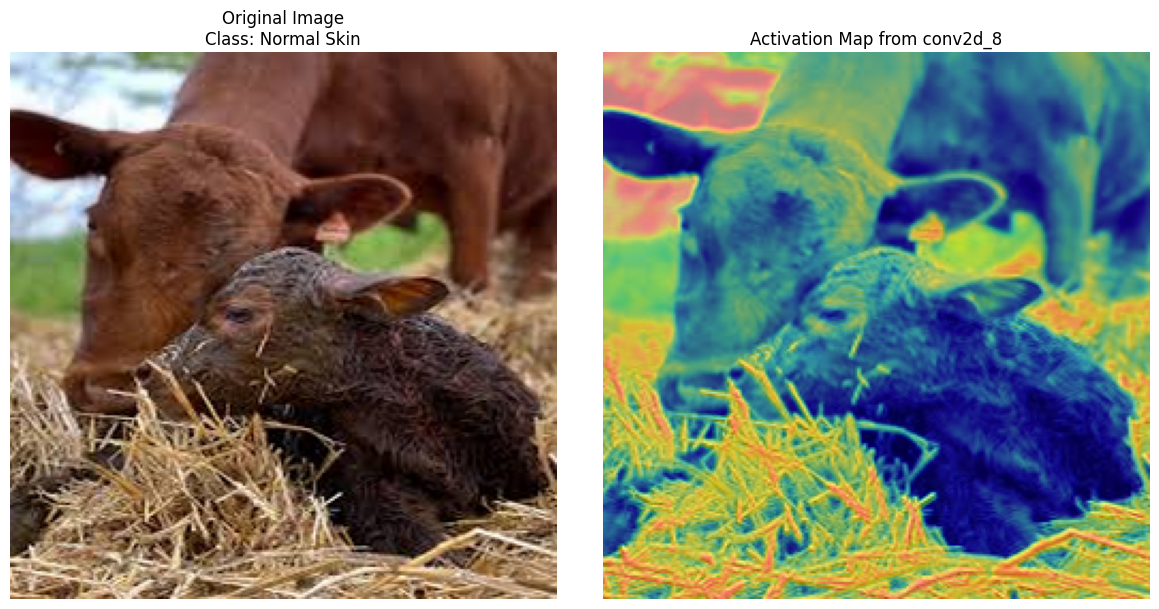


Trying layer: conv2d_9
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


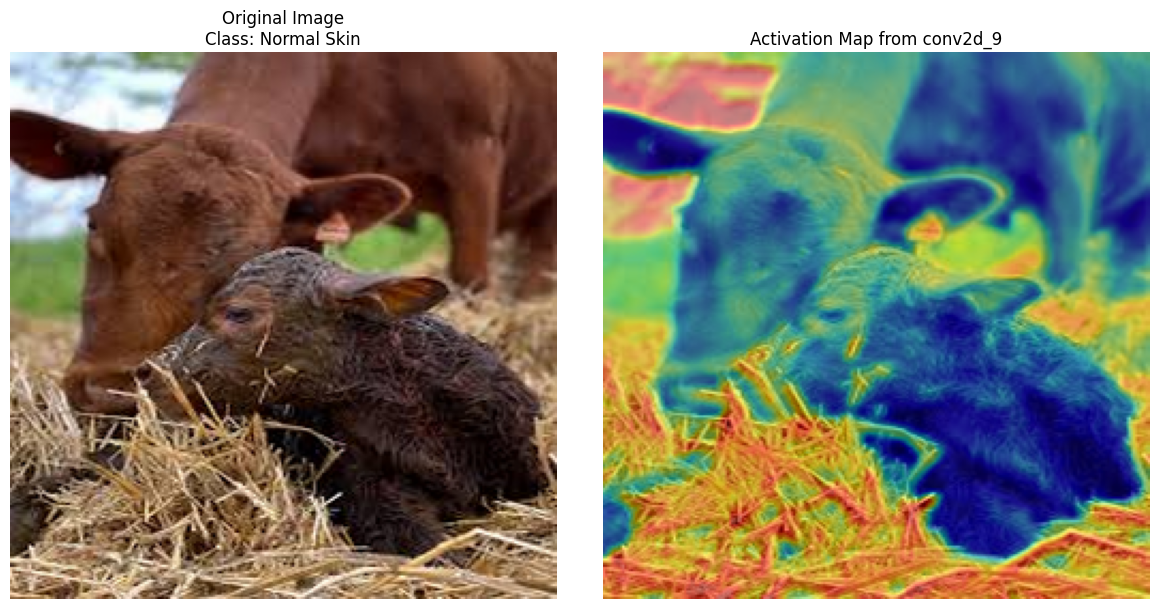


Trying layer: conv2d_10


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


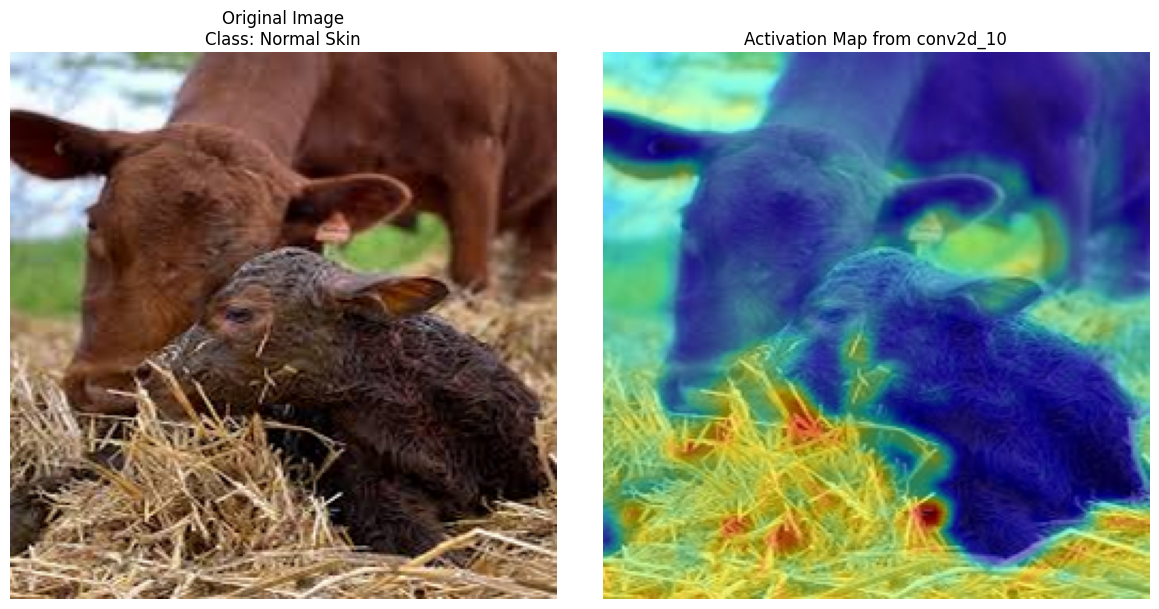


Trying layer: conv2d_11


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


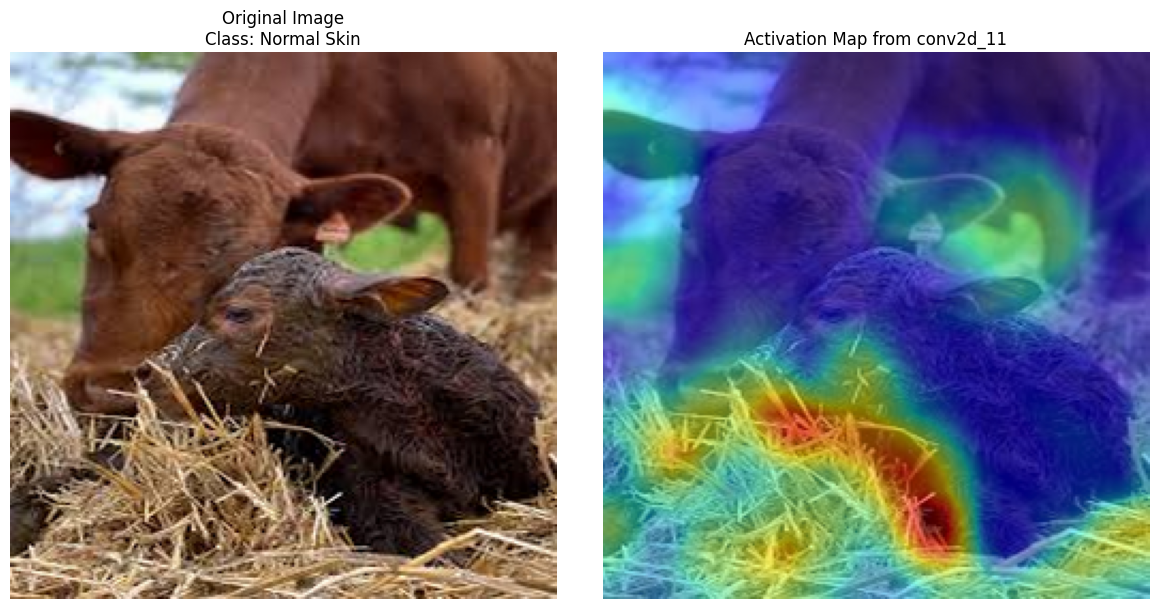

In [ ]:


# 1. Function to visualize activations without gradients
def visualize_activations(model, img_array, layer_name='conv2d_3'):
    # Create a submodel that outputs the specified layer's activations
    submodel = Model(inputs=model.inputs, outputs=model.get_layer(layer_name).output)

    # Get activations
    activations = submodel.predict(img_array)

    # Average across channels
    heatmap = np.mean(activations[0], axis=-1)

    # Normalize and resize
    heatmap = np.maximum(heatmap, 0)
    heatmap = heatmap / (heatmap.max() + 1e-8)
    heatmap = cv2.resize(heatmap, (img_array.shape[2], img_array.shape[1]))

    return heatmap

# 2. Prepare sample image
sample_img = X_test[0:1]
print("Input shape:", sample_img.shape)
print("Input range:", np.min(sample_img), "to", np.max(sample_img))

# 3. Test basic model prediction first
try:
    print("\nTesting basic model prediction...")
    pred = cnn_model.predict(sample_img)
    print("Prediction shape:", pred.shape)
    print("Predicted class:", "Lumpy Skin" if np.argmax(pred) == 1 else "Normal Skin")

    # 4. Try visualization with each convolutional layer
    for layer in cnn_model.layers:
        if isinstance(layer, tf.keras.layers.Conv2D):
            try:
                print(f"\nTrying layer: {layer.name}")
                heatmap = visualize_activations(cnn_model, sample_img, layer.name)

                # Visualization
                plt.figure(figsize=(12, 6))

                plt.subplot(1, 2, 1)
                plt.imshow(sample_img[0])
                plt.title(f"Original Image\nClass: {'Lumpy Skin' if y_test[0] else 'Normal Skin'}")
                plt.axis('off')

                plt.subplot(1, 2, 2)
                plt.imshow(sample_img[0])
                plt.imshow(heatmap, cmap='jet', alpha=0.5)
                plt.title(f"Activation Map from {layer.name}")
                plt.axis('off')

                plt.tight_layout()
                plt.show()

            except Exception as e:
                print(f"Failed with {layer.name}: {str(e)}")

except Exception as e:
    print("\nCritical error in model prediction:", str(e))
    print("\nImmediate actions:")
    print("1. Restart your runtime (Runtime → Restart runtime)")
    print("2. Verify model architecture with cnn_model.summary()")
    print("3. Check TensorFlow version (should be 2.x)")

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 8, 8, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 256)                 │       8,388,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,104,066 (88.14 MB)

 Trainable params: 8,389,378 (32.00 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 550s 28s/step - accuracy: 0.6110 - loss: 0.9431 - val_accuracy: 0.8062 - val_loss: 0.4161
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 157s 7s/step - accuracy: 0.7188 - loss: 0.4989 - val_accuracy: 0.7750 - val_loss: 0.4988
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 607s 29s/step - accuracy: 0.7671 - loss: 0.5184 - val_accuracy: 0.8687 - val_loss: 0.3579
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 143s 6s/step - accuracy: 0.7812 - loss: 0.5023 - val_accuracy: 0.8813 - val_loss: 0.3546
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 623s 30s/step - accuracy: 0.8185 - loss: 0.4162 - val_accuracy: 0.8500 - val_loss: 0.3770
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 132s 6s/step - accuracy: 0.7500 - loss: 0.4915 - val_accuracy: 0.8687 - val_loss: 0.3511
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 556s 28s/step - accuracy: 0.8565 - loss: 0.3562 - val_accuracy: 0.8625 - val_loss: 0.3486
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 142s 6s/step - accuracy: 0.9062 - loss: 0.1698 - val_accuracy: 0.8625

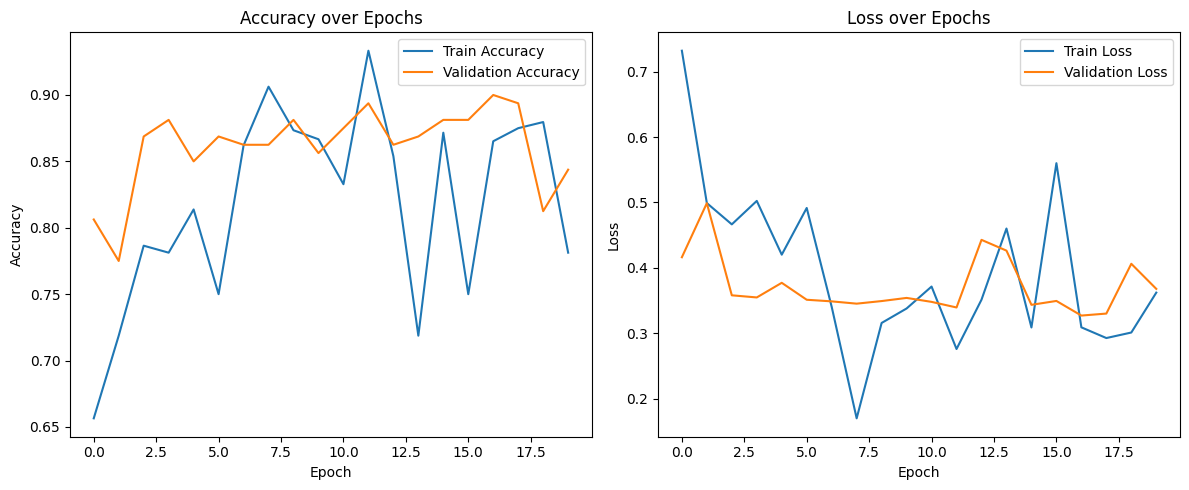

7/7 ━━━━━━━━━━━━━━━━━━━━ 144s 20s/step - accuracy: 0.8733 - loss: 0.4249
Pretrained Model Test Accuracy: 0.8878

Comparison:
Custom CNN Model Test Accuracy: 0.7707
Pretrained Model Test Accuracy: 0.8878


In [ ]:
# Using a Pre-trained Model (Transfer Learning )


def build_pretrained_model(input_shape=(256, 256, 3)):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze the base model
    base_model.trainable = False

    model = Sequential([
        base_model,
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(2, activation='softmax')
    ])

    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

# Build and summarize pretrained model
pretrained_model = build_pretrained_model()
pretrained_model.summary()

# Train the pretrained model
pretrained_history = pretrained_model.fit(
    train_generator,
    steps_per_epoch=len(X_train) // 32,
    epochs=20,
    validation_data=val_generator,
    validation_steps=len(X_val) // 32,
    callbacks=[early_stopping]
)

# Plot training history
plot_history(pretrained_history)

# Evaluate pretrained model
pretrained_test_loss, pretrained_test_acc = pretrained_model.evaluate(X_test, y_test_cat)
print(f"Pretrained Model Test Accuracy: {pretrained_test_acc:.4f}")

# Compare with our CNN model
print(f"\nComparison:")
print(f"Custom CNN Model Test Accuracy: {test_acc:.4f}")
print(f"Pretrained Model Test Accuracy: {pretrained_test_acc:.4f}")

In [ ]:
# Save the model
pretrained_model.save("lumpy_skin_disease_vgg16.h5")


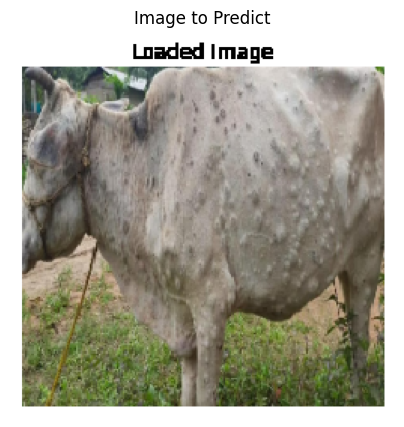

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 811ms/step

Predicted Class: Lumpy Skin
Confidence: 0.9807


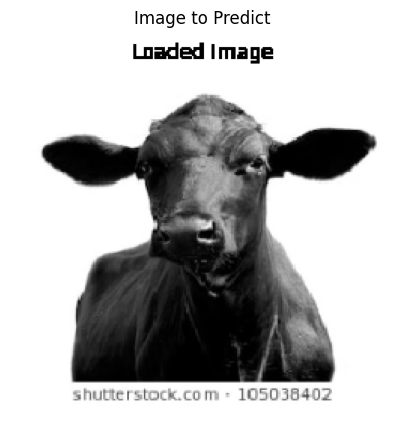

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 629ms/step

Predicted Class: Normal Skin
Confidence: 0.9347


In [ ]:
from tensorflow.keras.models import load_model
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Load the saved model
model = load_model("lumpy_skin_disease_vgg16.h5")

# Function to preprocess and predict
def predict_image(img_path):
    # Load and display the image
    img = image.load_img(img_path, target_size=(256, 256))
    plt.figure(figsize=(5, 5))
    plt.imshow(img)
    plt.axis('off')
    plt.title('Image to Predict')
    plt.show()

    # Preprocess the image
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array /= 255.0  # Normalize

    # Make prediction
    prediction = model.predict(img_array)
    class_idx = np.argmax(prediction)  # Get the predicted class index

    classes = ['Normal Skin', 'Lumpy Skin']
    print(f"\nPredicted Class: {classes[class_idx]}")
    print(f"Confidence: {prediction[0][class_idx]:.4f}")

# Example usage
predict_image(img_path='/content/drive/MyDrive/Lumpy Skin Images Dataset/Predict/prediction.png')

predict_image(img_path='/content/drive/MyDrive/Lumpy Skin Images Dataset/Predict/prediction1.png')


7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 141s 20s/step
Custom CNN Model:
              precision    recall  f1-score   support

 Normal Skin       0.83      0.84      0.83       140
  Lumpy Skin       0.65      0.62      0.63        65

    accuracy                           0.77       205
   macro avg       0.74      0.73      0.73       205
weighted avg       0.77      0.77      0.77       205


Pretrained VGG16 Model:
              precision    recall  f1-score   support

 Normal Skin       0.91      0.93      0.92       140
  Lumpy Skin       0.84      0.80      0.82        65

    accuracy                           0.89       205
   macro avg       0.87      0.86      0.87       205
weighted avg       0.89      0.89      0.89       205



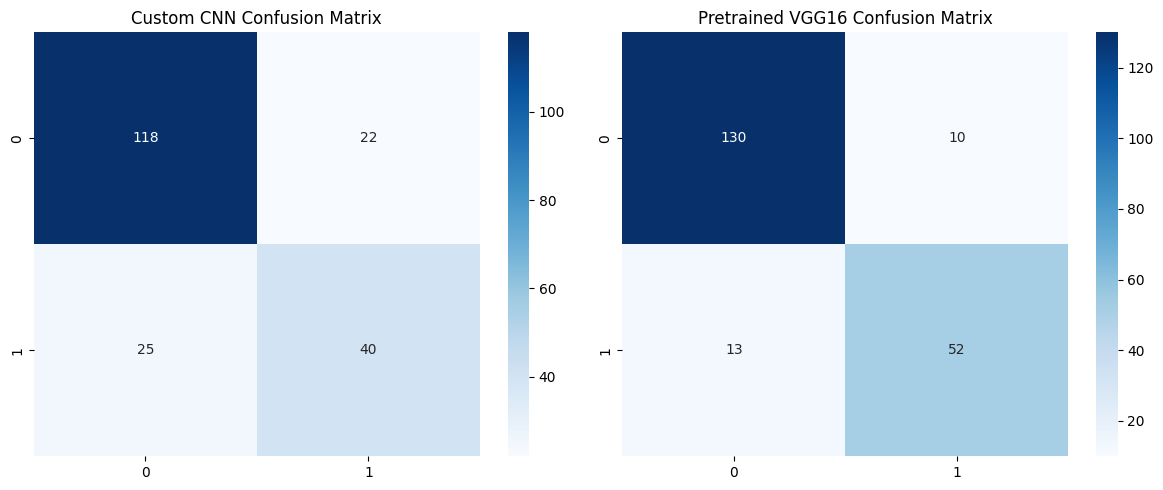

In [ ]:
# Final Evaluation and Discussion


# Compare both models comprehensively
def compare_models(cnn_model, pretrained_model, X_test, y_test):
    # Predictions
    cnn_pred = cnn_model.predict(X_test)
    cnn_pred_classes = np.argmax(cnn_pred, axis=1)

    pretrained_pred = pretrained_model.predict(X_test)
    pretrained_pred_classes = np.argmax(pretrained_pred, axis=1)

    # Classification reports
    print("Custom CNN Model:")
    print(classification_report(y_test, cnn_pred_classes, target_names=['Normal Skin', 'Lumpy Skin']))

    print("\nPretrained VGG16 Model:")
    print(classification_report(y_test, pretrained_pred_classes, target_names=['Normal Skin', 'Lumpy Skin']))

    # Confusion matrices
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    sns.heatmap(confusion_matrix(y_test, cnn_pred_classes), annot=True, fmt='d', cmap='Blues')
    plt.title('Custom CNN Confusion Matrix')

    plt.subplot(1, 2, 2)
    sns.heatmap(confusion_matrix(y_test, pretrained_pred_classes), annot=True, fmt='d', cmap='Blues')
    plt.title('Pretrained VGG16 Confusion Matrix')
    plt.tight_layout()
    plt.show()

compare_models(cnn_model, pretrained_model, X_test, y_test)